In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from time import time
from mclearn.experiment import ActiveExperiment, load_results, save_results
from mclearn.tools import log
from matplotlib.ticker import FuncFormatter
%matplotlib inline
sns.set_style('white')
warnings.filterwarnings('ignore')  # Ignore annoying numpy warnings

In [3]:
uci_sets = ['glass', 'ionosphere'] 

Thompson Sampling: testing effect of mu and tau/sigma

In [ ]:
for dataset in uci_sets:
    data_path = os.path.join('data', dataset + '.csv')
    data = pd.read_csv(data_path)
    X, y = data.iloc[:, 1:], data['target']
    for mu in [0.001, 0.005, 0.05, 0.5]:
        for var in [0.001, 0.005, 0.01, 0.02]:
            print(dataset, mu, var)
            save_name = 'thompson-{}-{}'.format(mu, var)
            expt = ActiveExperiment(
                X, y, dataset, 'thompson', scale=True,
                n_splits=10, n_jobs=10, ts_sigma=var,
                ts_tau=var, ts_mu=mu, save_name=save_name)
            expt.run_policies()

Testing effect of information density

In [ ]:
for dataset in uci_sets:
    data_path = os.path.join('data', dataset + '.csv')
    data = pd.read_csv(data_path)
    X, y = data.iloc[:, 1:], data['target']
    for policy in ['w-confidence', 'w-margin']:
        for gamma in [50, 60, 70, 90, 95, 99]:
            print(dataset, policy, gamma)
            save_name = '{}-gamma-{}'.format(policy, gamma)
            expt = ActiveExperiment(
                X, y, dataset, policy, scale=True,
                n_splits=10, n_jobs=10, gamma_percentile=gamma,
                save_name=save_name)
            expt.run_policies()

## Results

In [9]:
titles = {
    'f1': 'F1',
    'accuracy': 'Accuracy',
    'mpba': 'MPBA'
}

In [10]:
def plot_learning_curves(measure):
    format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
    fig = plt.figure(figsize=(15, 20))
    
    selected_methods = []
    for mu in [0.001, 0.005, 0.05, 0.5]:
        for var in [0.001, 0.005, 0.01, 0.02]:
            selected_methods.append('thompson-{}-{}'.format(mu, var))
    for (i, dataset) in enumerate(uci_sets):
        initial_n = 10
        
        learning_curves = {}
        for method in selected_methods:
            learning_curves[method] = load_results(dataset, method, measure, True)
            
        maximum = load_results(dataset, 'asymptote', 'asymptote_{}'.format(measure), True)
        sample_size = learning_curves['thompson-0.05-0.02'].shape[0] + 9

        ax = fig.add_subplot(4, 3, i + 1)
        for method in selected_methods:
            xticks = np.arange(initial_n, initial_n + len(learning_curves[method]))
            method_label = 'exp3++' if method == 'exp++' else method
            ax.plot(xticks, learning_curves[method], label=method_label, linewidth=1)

        ax.legend(loc='lower right', frameon=True)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
        ax.set_title(dataset)
        ax.tick_params(top='off')
        ax.set_ylabel(titles[measure])
#         ax.set_xscale("log")

        ax.plot([initial_n, sample_size], [maximum, maximum], ls='--', color='#377eb8')
        ax.set_xlim(initial_n, sample_size)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
#     fig.savefig('figures/learning_curves-thompson-{}-{}.pdf'.format(measure, data), bbox_inches='tight')

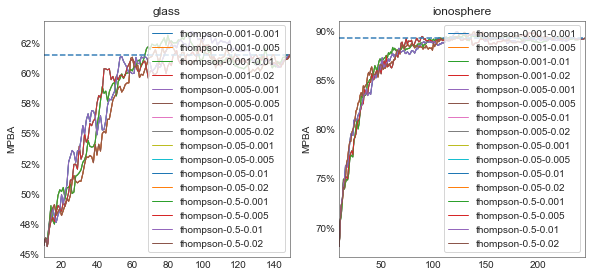

In [11]:
plot_learning_curves('mpba')

In [7]:
def calculate_strength(asymptote, passive, policy):
    n_trials, n_samples = passive.shape
    asymptote = np.repeat(asymptote, n_samples).reshape((n_trials, n_samples))
    deficiency = np.sum(asymptote - policy, axis=1) / np.sum(asymptote - passive, axis=1)
    strength = 1 - deficiency
    return strength

In [139]:
def plot_strength(measure='mpba', data='small'):
    fig = plt.figure(figsize=(10, 7))
    fig.subplots_adjust(hspace=.6)
    methods = []
    method_names = []
    
    for mu in [0.001, 0.005, 0.05, 0.5]:
        for var in [0.001, 0.005, 0.01, 0.02]:
            methods.append('thompson-{}-{}'.format(mu, var))
            method_names.append('μ={}, σ=τ={}'.format(mu, var))
            
    for (i, dataset) in enumerate(['glass', 'ionosphere']):
        results = {}
        for method in methods + ['passive']:
            results[method] = load_results(dataset, method, measure, mean=False)
        results['max'] = load_results(dataset, 'max', 'max_' + measure, False)
        strength_dict = {}
        for method in methods:
            s = calculate_strength(results['max'], results['passive'], results[method])
            strength_dict[method] = s
        strength_df = pd.DataFrame(strength_dict)
        strength_df.columns = ['μ={}, σ=τ={}'.format(x.split('-')[1], x.split('-')[2])
                               for x in strength_df.columns]
        sorted_cols = (-strength_df.median()).sort_values().index
        strength_df = strength_df[sorted_cols]

        ax = fig.add_subplot(2, 1, i + 1)
        strength_df.index.name = 'trial'
        strength_df = strength_df.reset_index()
        strength_df = strength_df.melt(id_vars=['trial'], value_vars=method_names)
#         strength_df.loc[strength_df['variable'].isin(methods_al), 'type'] = 'single'
#         strength_df.loc[strength_df['variable'].isin(methods_bandits), 'type'] = 'bandit'
#         strength_df.loc[strength_df['variable'].isin(methods_rank), 'type'] = 'rank'
#         strength_df.loc[strength_df['variable'] == 'baseline', 'variable'] = 'explore'
#         strength_df.loc[strength_df['variable'] == 'exp++', 'variable'] = 'exp3++'
        sorted_cols = list(sorted_cols)
#         sorted_cols[sorted_cols.index('baseline')] = 'explore'
#         sorted_cols[sorted_cols.index('exp++')] = 'exp3++'
        # We could use hue here, but I think there is a bug in seaborn that squishes
        # the boxplot
        

        sns.boxplot(data=strength_df, x='variable', y='value', order=sorted_cols,
                    width=0.4, linewidth=1, fliersize=3,
                    color=sns.color_palette()[2])
        ax.set_title(dataset)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')
        ax.xaxis.set_visible(True)
        ax.set_ylabel(titles[measure] + ' Strength')
        ax.set_xlabel('')
        ax.axhline(linewidth=1)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        
        # set bar width
        new_width = 0.5
        for bar in ax.patches:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + new_width / 2.

            bar.set_x(centre - new_width / 2.)
            bar.set_width(new_width)
            
    fig.savefig('figures/strengths-thompson-params.pdf'.format(measure, data), bbox_inches='tight')

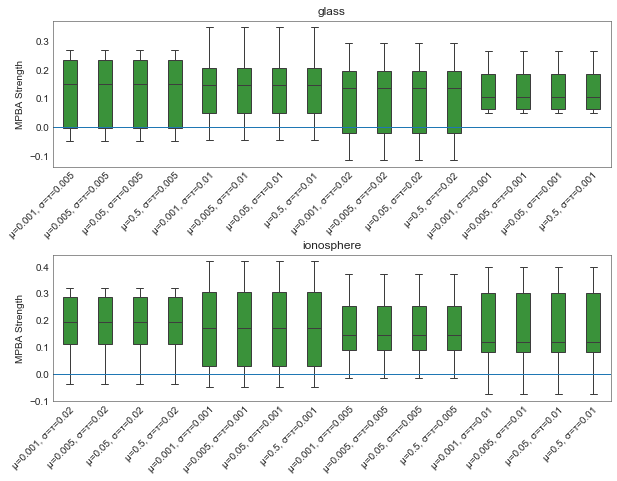

In [140]:
plot_strength('mpba')

In [20]:
colors = {'passive': '#e6ab02',
          'entropy': '#e7298a',
          'margin': '#d95f02',
          'qbb-margin': '#1b9e77',
          'qbb-kl': '#66a61e',
          'passive': '#7570b3',
          'confidence': '#a6761d'}

In [100]:
def plot_selections(dataset):
    fig = plt.figure(figsize=(15, 10))
    
    for i, mu in enumerate([0.001, 0.005, 0.05, 0.5]):
        for j, var in enumerate([0.001, 0.005, 0.01, 0.02]):
            method = 'thompson-{}-{}'.format(mu, var)
            
            ax = fig.add_subplot(4, 4, i * 4 + j  + 1)
            result = load_results(dataset, method)
            arms = ['passive', 'margin', 'confidence', 'entropy', 'qbb-margin', 'qbb-kl']
            total_n = sum(result['T'][0][-1])
            sample_sizes = np.arange(10, total_n + 10)
            trials = np.arange(1, total_n + 1)
            props = np.mean(result['T'], axis=0)[1:] / np.repeat(trials.reshape(-1, 1), 6, axis=1)
            df = pd.DataFrame(props, columns=arms)

            ordered_labels = df.iloc[-1].sort_values(ascending=False).index
            for label in ordered_labels:
                curve = df[label]
                inital_n = sample_sizes[0] - 1
                n_selections = sample_sizes - inital_n
                ax.plot(sample_sizes, curve, label=label, color=colors[label],
                    ls='-', linewidth=1)
            
            if i == 3:
                ax.set_xlabel('Training Size')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
            
            if j == 0:
                ax.set_ylabel('Frequency of Selections')
                format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
                ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
                
            if i == 0 and j == 0:
                ax.legend(loc='upper right', frameon=True)
            ax.set_title('μ={}, σ=τ={}'.format(mu, var))
            ax.set_ylim((0, 0.3))
            ax.set_xlim((10, total_n + 10))
            
        fig.savefig('figures/selection-thompson-params-{}.pdf'.format(dataset), bbox_inches='tight')

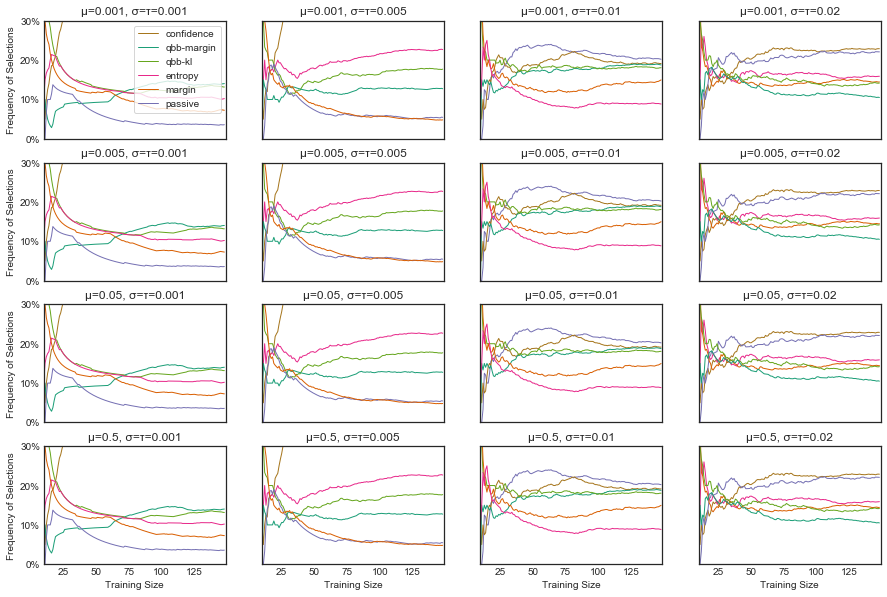

In [98]:
plot_selections('glass')

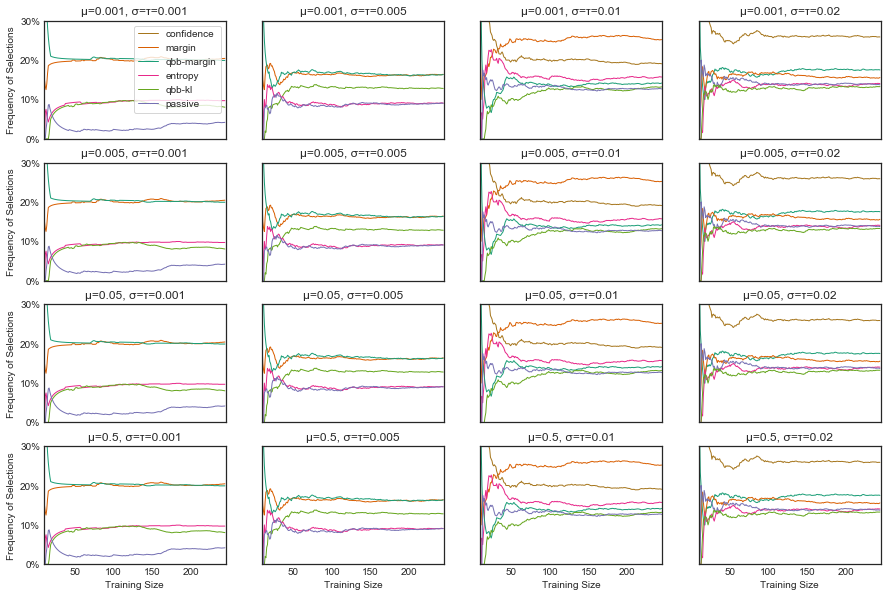

In [101]:
plot_selections('ionosphere')

## Information Density

In [104]:
def plot_learning_curves(measure):
    format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
    fig = plt.figure(figsize=(15, 20))
    
    selected_methods = []
    for policy in ['w-confidence', 'w-margin']:
        for gamma in [50, 60, 70, 90, 95, 99]:
            selected_methods.append('{}-gamma-{}'.format(policy, gamma))
    
    for (i, dataset) in enumerate(uci_sets):
        initial_n = 10
        
        learning_curves = {}
        for method in selected_methods:
            learning_curves[method] = load_results(dataset, method, measure, True)
            
        maximum = load_results(dataset, 'asymptote', 'asymptote_{}'.format(measure), True)
        sample_size = learning_curves['w-margin-gamma-50'].shape[0] + 9

        ax = fig.add_subplot(4, 3, i + 1)
        for method in selected_methods:
            xticks = np.arange(initial_n, initial_n + len(learning_curves[method]))
            method_label = 'exp3++' if method == 'exp++' else method
            ax.plot(xticks, learning_curves[method], label=method_label, linewidth=1)

        ax.legend(loc='lower right', frameon=True)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
        ax.set_title(dataset)
        ax.tick_params(top='off')
        ax.set_ylabel(titles[measure])
#         ax.set_xscale("log")

        ax.plot([initial_n, sample_size], [maximum, maximum], ls='--', color='#377eb8')
        ax.set_xlim(initial_n, sample_size)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
#     fig.savefig('figures/learning_curves-thompson-{}-{}.pdf'.format(measure, data), bbox_inches='tight')

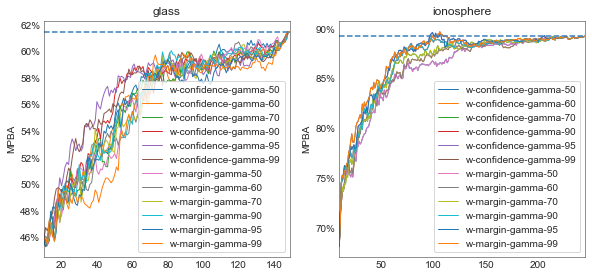

In [105]:
plot_learning_curves('mpba')

In [15]:
def plot_strength(measure='mpba', data='small'):
    fig = plt.figure(figsize=(10, 7))
    fig.subplots_adjust(hspace=.6)
    methods = []
    method_names = []
    
    for policy in ['w-confidence', 'w-margin']:
        for gamma in [50, 60, 70, 90, 95, 99]:
            methods.append('{}-gamma-{}'.format(policy, gamma))
            method_names.append('{}, {}th'.format(policy, gamma))
            
    for (i, dataset) in enumerate(['glass', 'ionosphere']):
        results = {}
        for method in methods + ['passive']:
            results[method] = load_results(dataset, method, measure, mean=False)
        results['max'] = load_results(dataset, 'max', 'max_' + measure, False)
        strength_dict = {}
        for method in methods:
            s = calculate_strength(results['max'], results['passive'], results[method])
            strength_dict[method] = s
        strength_df = pd.DataFrame(strength_dict)
        strength_df.columns = ['{}-{}, {}th'.format(x.split('-')[0], x.split('-')[1], x.split('-')[3])
                               for x in strength_df.columns]
        sorted_cols = (-strength_df.median()).sort_values().index
        strength_df = strength_df[sorted_cols]

        ax = fig.add_subplot(2, 1, i + 1)
        strength_df.index.name = 'trial'
        strength_df = strength_df.reset_index()
        strength_df = strength_df.melt(id_vars=['trial'], value_vars=method_names)
#         strength_df.loc[strength_df['variable'].isin(methods_al), 'type'] = 'single'
#         strength_df.loc[strength_df['variable'].isin(methods_bandits), 'type'] = 'bandit'
#         strength_df.loc[strength_df['variable'].isin(methods_rank), 'type'] = 'rank'
#         strength_df.loc[strength_df['variable'] == 'baseline', 'variable'] = 'explore'
#         strength_df.loc[strength_df['variable'] == 'exp++', 'variable'] = 'exp3++'
        sorted_cols = list(sorted_cols)
#         sorted_cols[sorted_cols.index('baseline')] = 'explore'
#         sorted_cols[sorted_cols.index('exp++')] = 'exp3++'
        # We could use hue here, but I think there is a bug in seaborn that squishes
        # the boxplot
        
        
        sns.boxplot(data=strength_df, x='variable', y='value', order=sorted_cols,
                    width=0.4, linewidth=1, fliersize=3,
                    color=sns.color_palette()[2])
        ax.set_title(dataset)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')
        ax.xaxis.set_visible(True)
        ax.set_ylabel(titles[measure] + ' Strength')
        ax.set_xlabel('')
        ax.axhline(linewidth=1)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        
        # set bar width
        new_width = 0.5
        for bar in ax.patches:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + new_width / 2.

            bar.set_x(centre - new_width / 2.)
            bar.set_width(new_width)
            
    fig.savefig('figures/strengths-info_density-params.pdf'.format(measure, data), bbox_inches='tight')

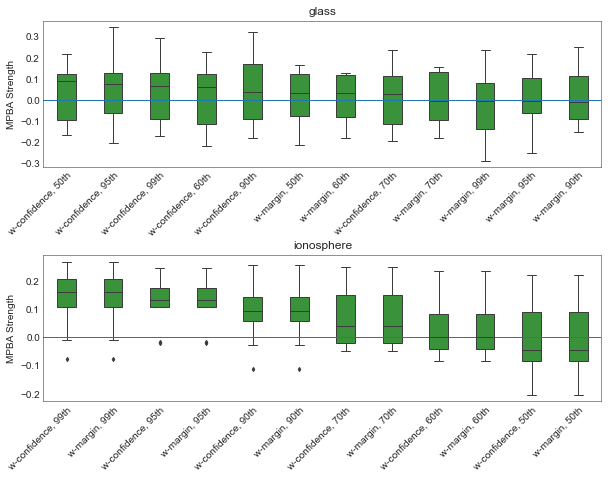

In [16]:
plot_strength()

## Smaller Pool

In [6]:
methods_al =  ['baseline', 'margin', 'w-margin', 'confidence',
            'w-confidence', 'entropy', 'w-entropy',
            'qbb-margin', 'qbb-kl']
methods_bandits = ['thompson', 'ocucb', 'klucb', 'exp++',]
methods_rank = ['borda', 'geometric', 'schulze']
methods_no_passive = methods_al + methods_bandits + methods_rank
methods = ['passive'] + methods_no_passive
measures = ['f1', 'accuracy', 'mpba']

In [17]:
for (i, dataset) in enumerate(['sdss-small-train', 'pageblocks-small-train', 'sdss-small-pool', 'pageblocks-small-pool']):
    maximum = {}
    for measure in measures:
        asymptote_measure = 'asymptote_' + measure
        max_measure = 'max_' + measure
        results = {}
        for method in methods:
            results[method] = load_results(dataset, method, measure, False)
            results[method] = np.max(results[method], axis=1)
        results['asymptote'] = load_results(dataset, 'asymptote', asymptote_measure, False)
        maximum[max_measure] = results['asymptote']
        for method in methods:
            maximum[max_measure] = np.maximum(maximum[max_measure], max(results[method]))
    save_results(dataset, 'max', maximum)

In [8]:
def calculate_strength(asymptote, passive, policy):
    n_trials, n_samples = passive.shape
    asymptote = np.repeat(asymptote, n_samples).reshape((n_trials, n_samples))
    deficiency = np.sum(asymptote - policy, axis=1) / np.sum(asymptote - passive, axis=1)
    strength = 1 - deficiency
    return strength

In [9]:
titles = {
    'f1': 'F1',
    'accuracy': 'Accuracy',
    'mpba': 'MPBA'
}

In [32]:
def plot_mpba_strength(measure, datasets):
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=.6)
    
    for (i, dataset) in enumerate(datasets):
        results = {}
        for method in methods:
            results[method] = load_results(dataset, method, measure, mean=False)
        results['max'] = load_results(dataset, 'max', 'max_' + measure, False)
        strength_dict = {}
        for method in methods_no_passive:
            s = calculate_strength(results['max'], results['passive'], results[method])
            strength_dict[method] = s
        strength_df = pd.DataFrame(strength_dict)
        sorted_cols = (-strength_df.median()).sort_values().index
        strength_df = strength_df[sorted_cols]

        ax = fig.add_subplot(3, 2, i + 1)
        strength_df.index.name = 'trial'
        strength_df = strength_df.reset_index()
        strength_df = strength_df.melt(id_vars=['trial'], value_vars=methods_no_passive)
        strength_df.loc[strength_df['variable'].isin(methods_al), 'type'] = 'single'
        strength_df.loc[strength_df['variable'].isin(methods_bandits), 'type'] = 'bandit'
        strength_df.loc[strength_df['variable'].isin(methods_rank), 'type'] = 'rank'
        strength_df.loc[strength_df['variable'] == 'baseline', 'variable'] = 'explore'
        strength_df.loc[strength_df['variable'] == 'exp++', 'variable'] = 'exp3++'
        sorted_cols = list(sorted_cols)
        sorted_cols[sorted_cols.index('baseline')] = 'explore'
        sorted_cols[sorted_cols.index('exp++')] = 'exp3++'
        # We could use hue here, but I think there is a bug in seaborn that squishes
        # the boxplot
        
        palette_map = {
            **{m: sns.color_palette()[0] for m in methods_al},
            **{m: sns.color_palette()[2] for m in ['thompson', 'ocucb', 'klucb', 'exp3++', 'explore']},
            **{m: sns.color_palette()[1] for m in methods_rank},
        }
        sns.boxplot(data=strength_df, x='variable', y='value', order=sorted_cols,
                    width=0.4, linewidth=1, palette=palette_map, fliersize=3)
        
        if '-' in dataset:
            dataset, size, kind = dataset.split('-')
            if size == 'small' and kind == 'train':
                title = '{} (small training set)'.format(dataset)
            elif size == 'small' and kind == 'pool':
                title = '{} (small training and test sets)'.format(dataset)
        else:
            title = '{} (full dataset)'.format(dataset)
        ax.set_title(title)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode='anchor', ha='right')
        ax.xaxis.set_visible(True)
        ax.set_ylabel(titles[measure] + ' Strength')
        ax.set_xlabel('')
        ax.axhline(linewidth=1)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        
        # set bar width
        new_width = 0.5
        for bar in ax.patches:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + new_width / 2.

            bar.set_x(centre - new_width / 2.)
            bar.set_width(new_width)
            
    fig.savefig('figures/strengths-pool-{}.pdf'.format(measure), bbox_inches='tight')

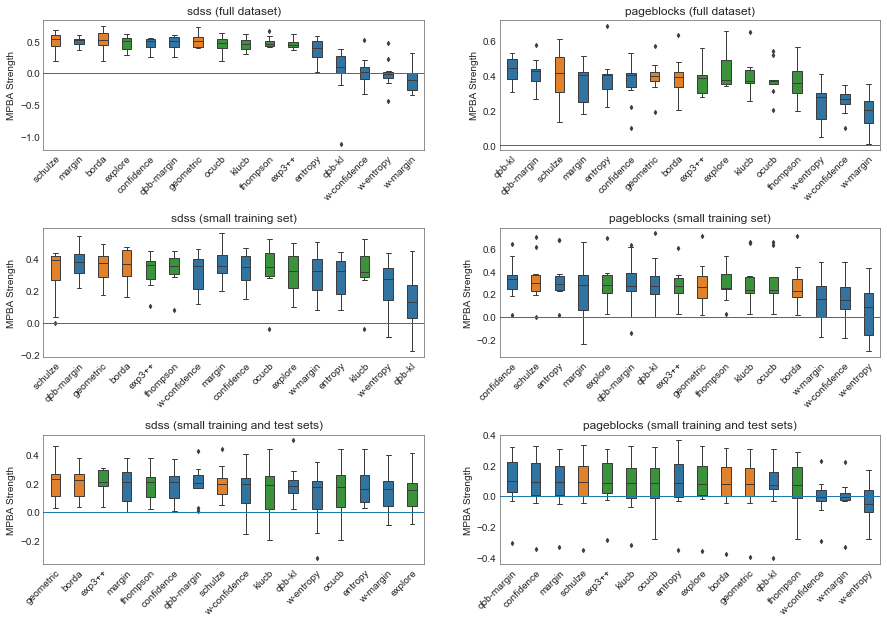

In [33]:
plot_mpba_strength('mpba', ['sdss', 'pageblocks', 'sdss-small-train' ,'pageblocks-small-train', 'sdss-small-pool' ,'pageblocks-small-pool'])

In [65]:
def plot_learning_curves(measure, datasets):
    selected_methods = ['passive', 'confidence', 'borda', 'exp++']
    format_as_percent_plot = lambda x, pos: "{:.0f}%".format(x * 100)
    fig = plt.figure(figsize=(15, 10))
    for (i, dataset) in enumerate(datasets):
        initial_n = 10
        
        learning_curves = {}
        for method in selected_methods:
            learning_curves[method] = load_results(dataset, method, measure, True)
            
        maximum = load_results(dataset, 'asymptote', 'asymptote_{}'.format(measure), True)
#         maximum = np.max(maximum)
        sample_size = learning_curves['passive'].shape[0] + 9

        ax = fig.add_subplot(2, 3, i + 1)
        for method in selected_methods:
            xticks = np.arange(initial_n, initial_n + len(learning_curves[method]))
            method_label = 'exp3++' if method == 'exp++' else method
            ax.plot(xticks, learning_curves[method], label=method_label, linewidth=1)

        ax.legend(loc='lower right', frameon=True)
        ax.get_yaxis().set_major_formatter(FuncFormatter(format_as_percent_plot))
        if '-' in dataset:
            dataset, size, kind = dataset.split('-')
            if size == 'small' and kind == 'train':
                title = '{} (small training set)'.format(dataset)
            elif size == 'small' and kind == 'pool':
                title = '{} (small training and test sets)'.format(dataset)
        else:
            title = '{} (full dataset)'.format(dataset)
        ax.set_title(title)
        ax.tick_params(top='off')
        ax.set_ylabel(titles[measure])
#         ax.set_xscale("log")

        ax.plot([initial_n, sample_size], [maximum, maximum], ls='--', color='#377eb8')
#         ax.set_xlim(initial_n, sample_size)
        ax.set_xlim(initial_n, 201)
        if 'sdss' in dataset:
            ax.set_ylim(0.63, 0.91)
        else:
            ax.set_ylim(0.45, 0.78)
        [i.set_linewidth(0.5) for i in ax.spines.values()]
    fig.savefig('figures/learning_curves-pool-{}.pdf'.format(measure), bbox_inches='tight')

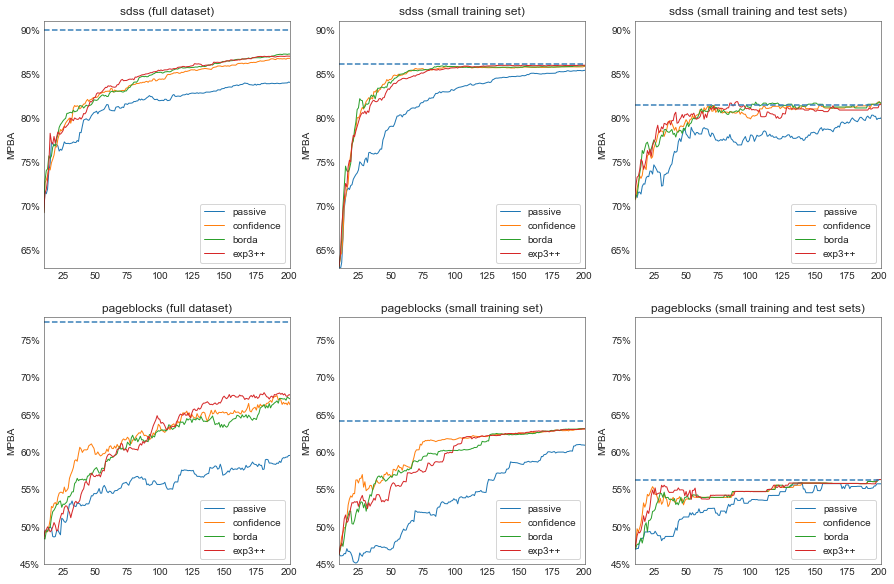

In [67]:
plot_learning_curves('mpba', ['sdss', 'sdss-small-train', 'sdss-small-pool', 'pageblocks', 'pageblocks-small-train', 'pageblocks-small-pool'])